   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 3.1 MB/s eta 0:00:00
Please upload your CSV/Excel file.


Saving D1.xlsx to D1.xlsx


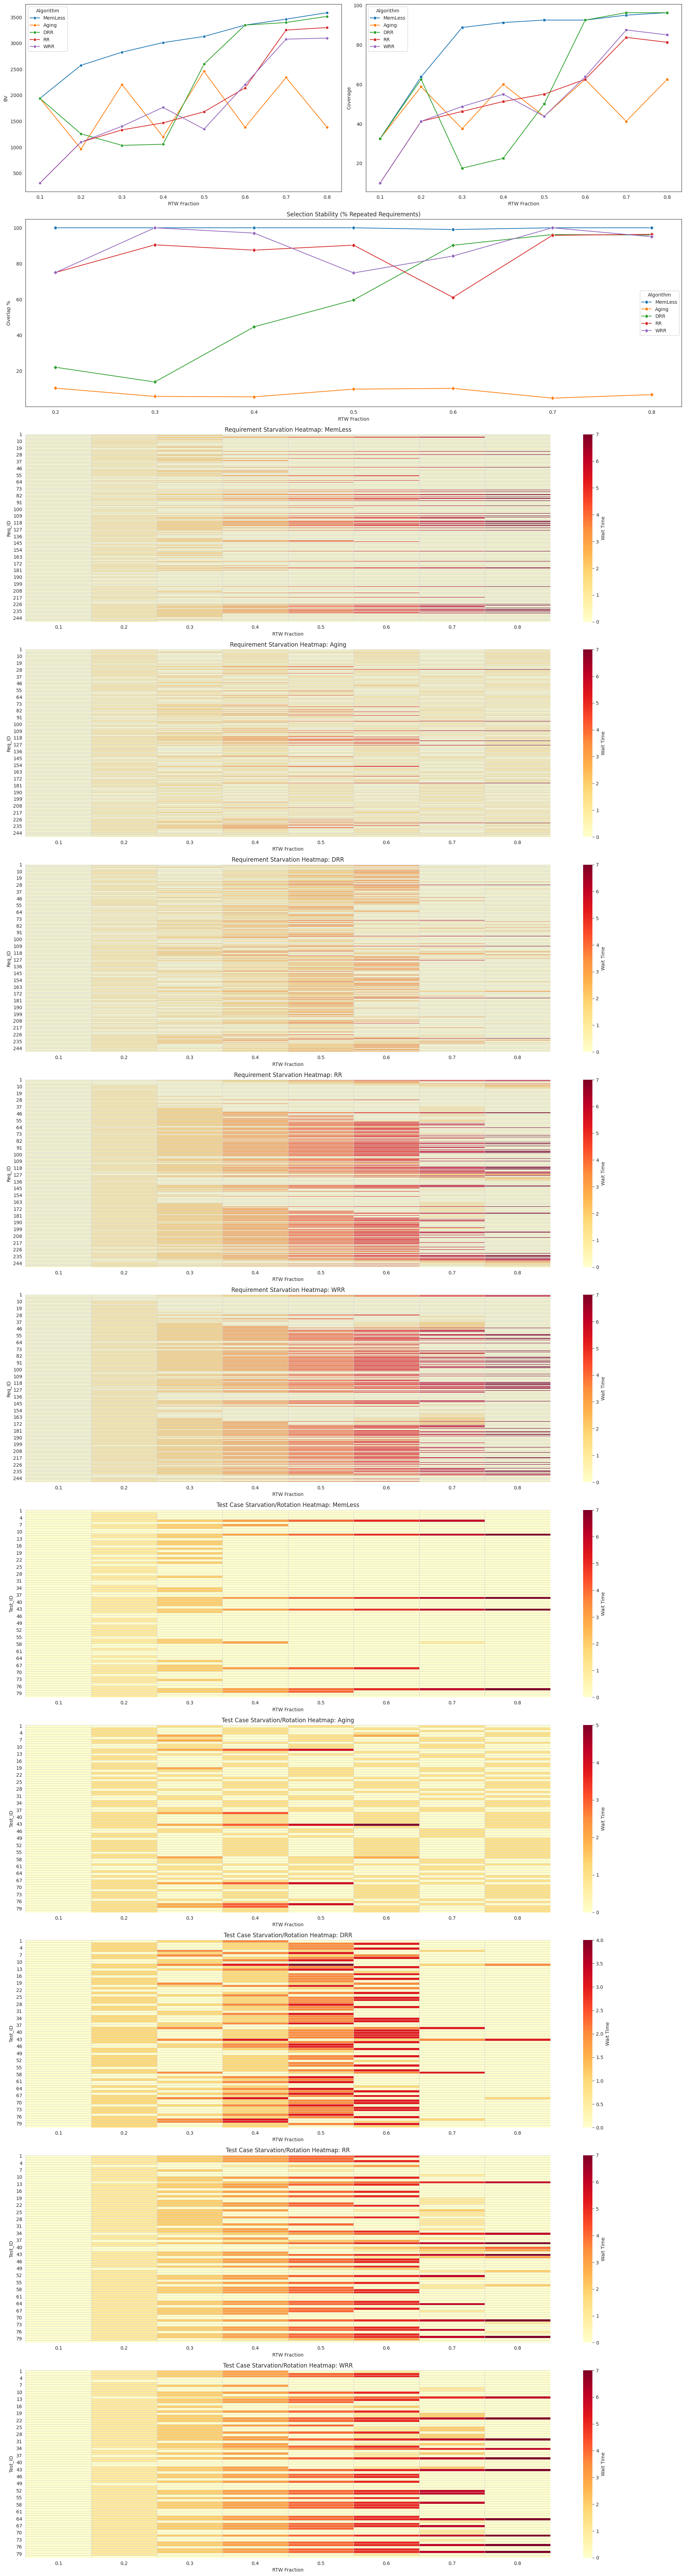

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
# 1. Install required libraries
!pip install xlsxwriter openpyxl seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import os
from typing import Dict, Any, Sequence
from google.colab import files

# --------------------------------------------------------------------
# 1. FILE UPLOAD
# --------------------------------------------------------------------
print("Please upload your CSV/Excel file.")
uploaded = files.upload()

if not uploaded:
    print("No file uploaded.")
else:
    filename = list(uploaded.keys())[0]
    df_input = pd.read_excel(io.BytesIO(uploaded[filename])) if filename.lower().endswith(('.xlsx', '.xls')) else pd.read_csv(io.BytesIO(uploaded[filename]), encoding='utf-8', errors='replace')

    RTW_FRACTIONS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

    # --------------------------------------------------------------------
    # 2. CORE LOGIC & PIPELINE
    # --------------------------------------------------------------------
    def build_model(df):
        t_ids, r_ids = np.sort(df["tc_id"].unique()), np.sort(df["us_id"].unique())
        t_idx, r_idx = {id: i for i, id in enumerate(t_ids)}, {id: i for i, id in enumerate(r_ids)}
        t_et = np.array([float(df[df["tc_id"]==id]["tc_executiontime"].iloc[0]) for id in t_ids])
        r_bv = np.array([float(df[df["us_id"]==id]["us_businessvalue"].iloc[0]) for id in r_ids])

        # Mapping for Greedy/Aging/DRR
        t_to_r = [np.array([r_idx[u] for u in df[df["tc_id"]==id]["us_id"]]) for id in t_ids]
        r_tc = np.array([len(df[df["us_id"]==id]) for id in r_ids])

        # Mapping for RR/WRR (Requirement -> List of Test Indices)
        r_to_t = [[] for _ in range(len(r_ids))]
        for _, row in df.iterrows():
            r_to_t[r_idx[row["us_id"]]].append(t_idx[row["tc_id"]])
        r_to_t = [np.array(tlist) for tlist in r_to_t]

        return {
            "t_ids": t_ids, "r_ids": r_ids, "t_et": t_et, "r_bv": r_bv,
            "t_to_r": t_to_r, "r_tc": r_tc, "r_to_t": r_to_t,
            "n_t": len(t_ids), "n_r": len(r_ids)
        }

    # Original Greedy-based runner for MemLess, Aging, DRR
    def run_algo_greedy(m, budget, w=None, defs=None):
        sel_t, u_et = np.zeros(m["n_t"], dtype=bool), 0.0
        r_cnt, r_sat = np.zeros(m["n_r"], dtype=int), np.zeros(m["n_r"], dtype=bool)
        while True:
            best_t, best_s, fair = -1, 0.0, False
            cands = []
            for ti in range(m["n_t"]):
                if sel_t[ti] or (u_et + m["t_et"][ti] > budget): continue
                fb, bg = 0.0, 0.0
                for rj in m["t_to_r"][ti]:
                    if not r_sat[rj] and (r_cnt[rj]+1 == m["r_tc"][rj]):
                        bg += m["r_bv"][rj] * (w[rj] if w is not None else 1.0)
                        if defs is not None and defs[rj] > 0: fb += defs[rj]
                cands.append((ti, fb, bg)); fair = fair or (fb > 0)
            for ti, fb, bg in cands:
                score = (fb if fair else bg) / m["t_et"][ti]
                if score > best_s: best_s, best_t = score, ti
            if best_t == -1: break
            sel_t[best_t], u_et = True, u_et + m["t_et"][best_t]
            for rj in m["t_to_r"][best_t]:
                if not r_sat[rj]:
                    r_cnt[rj]+=1
                    if r_cnt[rj] == m["r_tc"][rj]: r_sat[rj] = True
        return {"sat": r_sat, "tests": sel_t, "bv": m["r_bv"][r_sat].sum(), "cvg": 100.0 * sel_t.sum() / m["n_t"]}

    # RR/WRR runner
    def run_algo_round_robin(m, budget, order, start_head):
        sel_t, u_et = np.zeros(m["n_t"], dtype=bool), 0.0
        r_sat = np.zeros(m["n_r"], dtype=bool)
        L = len(order)
        head = start_head % L
        added = True

        while added and u_et < budget:
            added = False
            for offset in range(L):
                idx = (head + offset) % L
                rj = order[idx]
                if r_sat[rj]: continue

                # Calculate extra ET needed for this requirement
                t_indices = m["r_to_t"][rj]
                extra_et = sum(m["t_et"][ti] for ti in t_indices if not sel_t[ti])

                if extra_et == 0: # Already covered by previous requirements
                    r_sat[rj] = True
                    added = True
                    continue

                if u_et + extra_et <= budget:
                    for ti in t_indices: sel_t[ti] = True
                    u_et += extra_et
                    r_sat[rj] = True
                    added = True
            head = (head + 1) % L

        return {"sat": r_sat, "tests": sel_t, "bv": m["r_bv"][r_sat].sum(), "cvg": 100.0 * sel_t.sum() / m["n_t"], "last_head": head}

    # Execution Loop
    m = build_model(df_input)
    algos = ["MemLess", "Aging", "DRR", "RR", "WRR"]
    perf, stab = [], []
    hm_r, hm_t = {a: [] for a in algos}, {a: [] for a in algos}
    sel_mat_r, sel_mat_t = {a: [] for a in algos}, {a: [] for a in algos}

    r_wait, t_wait = {a: np.zeros(m["n_r"]) for a in algos}, {a: np.zeros(m["n_t"]) for a in algos}
    age, s_cnt, p_sets = np.ones(m["n_r"]), np.zeros(m["n_r"]), {a: set() for a in algos}

    # State for RR/WRR
    rr_head, wrr_head = 0, 0
    rr_order = np.arange(m["n_r"])
    # WRR weights based on BV
    avg_bv = m["r_bv"].mean() if m["r_bv"].sum() > 0 else 1.0
    wrr_weights = np.clip(np.round(m["r_bv"] / avg_bv), 1, 5).astype(int)
    wrr_order = np.array([idx for idx, w in enumerate(wrr_weights) for _ in range(w)])

    for k, frac in enumerate(RTW_FRACTIONS, 1):
        budget = frac * m["t_et"].sum()
        for a in algos:
            if a == "MemLess":
                res = run_algo_greedy(m, budget)
            elif a == "Aging":
                res = run_algo_greedy(m, budget, w=age)
            elif a == "DRR":
                res = run_algo_greedy(m, budget, defs=((k * m["r_bv"] / m["r_bv"].sum()) - s_cnt))
            elif a == "RR":
                res = run_algo_round_robin(m, budget, rr_order, rr_head)
                rr_head = res["last_head"]
            elif a == "WRR":
                res = run_algo_round_robin(m, budget, wrr_order, wrr_head)
                wrr_head = res["last_head"]

            perf.append({"Algorithm": a, "RTW Fraction": frac, "BV": res["bv"], "Coverage": res["cvg"]})

            # Record States
            for j in range(m["n_r"]):
                hm_r[a].append({"RTW Fraction": frac, "Req_ID": m["r_ids"][j], "Wait": r_wait[a][j]})
                sel_mat_r[a].append({"RTW Fraction": frac, "Req_ID": m["r_ids"][j], "Selected": int(res["sat"][j])})
            for j in range(m["n_t"]):
                hm_t[a].append({"RTW Fraction": frac, "Test_ID": m["t_ids"][j], "Wait": t_wait[a][j]})
                sel_mat_t[a].append({"RTW Fraction": frac, "Test_ID": m["t_ids"][j], "Selected": int(res["tests"][j])})

            curr = set(m["r_ids"][res["sat"]])
            if k > 1: stab.append({"Algorithm": a, "RTW Fraction": frac, "Overlap_Pct": (len(p_sets[a].intersection(curr))/len(p_sets[a])*100) if p_sets[a] else 0})

            # Updates
            r_wait[a] += 1; r_wait[a][res["sat"]] = 0
            t_wait[a] += 1; t_wait[a][res["tests"]] = 0
            if a == "Aging": age += 1.0; age[res["sat"]] = 0.0
            if a == "DRR": s_cnt += res["sat"].astype(float)
            p_sets[a] = curr

    # --------------------------------------------------------------------
    # 3. VISUALIZATION
    # --------------------------------------------------------------------
    sns.set_style("white")
    plt.rcParams['figure.facecolor'] = 'white'

    # 2 Summary rows + 5 Req heatmaps + 5 Test heatmaps = 12 rows total
    fig = plt.figure(figsize=(20, 75), facecolor='white')
    gs = fig.add_gridspec(12, 2)

    ax1 = fig.add_subplot(gs[0,0]); sns.lineplot(data=pd.DataFrame(perf), x="RTW Fraction", y="BV", hue="Algorithm", marker='o', ax=ax1)
    ax2 = fig.add_subplot(gs[0,1]); sns.lineplot(data=pd.DataFrame(perf), x="RTW Fraction", y="Coverage", hue="Algorithm", marker='s', ax=ax2)
    ax3 = fig.add_subplot(gs[1,:]); sns.lineplot(data=pd.DataFrame(stab), x="RTW Fraction", y="Overlap_Pct", hue="Algorithm", marker='D', ax=ax3)
    ax3.set_title("Selection Stability (% Repeated Requirements)"); ax3.set_ylabel("Overlap %")

    # Requirement Heatmaps (Rows 2 to 6)
    for i, a in enumerate(algos):
        ax = fig.add_subplot(gs[i+2,:])
        pivot = pd.DataFrame(hm_r[a]).pivot(index="Req_ID", columns="RTW Fraction", values="Wait")
        sns.heatmap(pivot, cmap="YlOrRd", ax=ax, linewidths=.5, linecolor='lightgrey', cbar_kws={'label': 'Wait Time'})
        ax.set_title(f"Requirement Starvation Heatmap: {a}")

    # Test Heatmaps (Rows 7 to 11)
    for i, a in enumerate(algos):
        ax = fig.add_subplot(gs[i+7,:])
        pivot = pd.DataFrame(hm_t[a]).pivot(index="Test_ID", columns="RTW Fraction", values="Wait")
        sns.heatmap(pivot, cmap="YlOrRd", ax=ax, linewidths=.5, linecolor='lightgrey', cbar_kws={'label': 'Wait Time'})
        ax.set_title(f"Test Case Starvation/Rotation Heatmap: {a}")

    plt.tight_layout()
    plt.savefig("analysis.png", facecolor='white')
    plt.show()

    # --------------------------------------------------------------------
    # 4. EXCEL REPORT
    # --------------------------------------------------------------------
    out = "Algorithm_Repetition_Report.xlsx"
    with pd.ExcelWriter(out, engine='xlsxwriter') as writer:
        pd.DataFrame(perf).to_excel(writer, sheet_name='Summary', index=False)
        workbook = writer.book
        viz_sheet = workbook.add_worksheet('Visualizations')
        viz_sheet.insert_image('A1', 'analysis.png', {'x_scale': 0.4, 'y_scale': 0.4})

        for a in algos:
            pd.DataFrame(sel_mat_r[a]).pivot(index="Req_ID", columns="RTW Fraction", values="Selected").to_excel(writer, sheet_name=f'Sel_Req_{a}')
            pd.DataFrame(hm_r[a]).pivot(index="Req_ID", columns="RTW Fraction", values="Wait").to_excel(writer, sheet_name=f'Wait_Req_{a}')
            pd.DataFrame(sel_mat_t[a]).pivot(index="Test_ID", columns="RTW Fraction", values="Selected").to_excel(writer, sheet_name=f'Sel_Test_{a}')
            pd.DataFrame(hm_t[a]).pivot(index="Test_ID", columns="RTW Fraction", values="Wait").to_excel(writer, sheet_name=f'Wait_Test_{a}')

    files.download(out)